# 2. Pipelines

So far, we used Scikit-learn for its ML estimators like the LinearRegression or Ridge ones and saw a few examples of transformers with the StandardScaler and PolynomialFeatures objects. In this unit and the next ones, we will see how to assemble Scikit-learn estimators and transformers into a full ML pipeline.

In this unit, we will see how to use the Pipeline object from Scikit-learn using the bike sharing data.

__Encapsulating preprocessing steps__

In [1]:
import pandas as pd

data_df = pd.read_csv("c3_bike-sharing-data.csv")
data_df.head()

,temp,hum,windspeed,yr,workingday,holiday,weekday,season,weathersit,casual
0,0.344,0.806,0.160,2011,no,no,6,spring,cloudy,331
1,0.363,0.696,0.249,2011,no,no,0,spring,cloudy,131
2,0.196,0.437,0.248,2011,yes,no,1,spring,clear,120
3,0.200,0.590,0.160,2011,yes,no,2,spring,clear,108
4,0.227,0.437,0.187,2011,yes,no,3,spring,clear,82


In [2]:
from sklearn.model_selection import train_test_split

# One-hot encoding
encoded_df = pd.get_dummies(data_df)

# Split into train/test sets
X = encoded_df.drop("casual", axis=1).values
y = data_df.casual.values
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

In [3]:
from sklearn.preprocessing import StandardScaler

# Standardize data
scaler = StandardScaler()
X_tr_rescaled = scaler.fit_transform(X_tr)
X_te_rescaled = scaler.transform(X_te)

In [4]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_tr_rescaled, y_tr)
print("MAE: {:.2f}".format(MAE(y_te, ridge.predict(X_te))))

MAE: 255890.12


The pipeline object can be used as a standard Scikit-learn estimator i.e. it implements the usual fit(), predict() and score() functions from the estimator API.

In [6]:
import numpy as np

median_predictions = np.full_like(y_te, np.median(y_tr))
print("Median baseline: {:.2f}".format(MAE(y_te, median_predictions)))

Median baseline: 523.47


In [7]:
print("MAE: {:.2f}".format(MAE(y_te, ridge.predict(X_te_rescaled))))

MAE: 279.80


__Pipeline object__

In [11]:
from sklearn.pipeline import Pipeline

# Create pipeline
pipe = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge())])

In [12]:
# Get a dictionary with each step
pipe.named_steps

{'scaler': StandardScaler(), 'ridge': Ridge()}

In [13]:
# Fit on the train set
pipe.fit(X_tr, y_tr)

# Evaluate on the test set
print("MAE: {:.2f}".format(MAE(y_te, pipe.predict(X_te))))

MAE: 279.80


__Multiple preprocessing steps__

In the example above, we have a single preprocessing step. The pipe.fit() call is equivalent to applying the following handmade function:

In [8]:
def pipe_fit(X, y):
    # Fit and apply the transformation
    X1 = scaler.fit_transform(X)

    # Fit the estimator
    ridge.fit(X1, y)


# Fit to the train data
pipe_fit(X_tr, y_tr)

Similarly, the pipe.predict() call above is equivalent to:

In [9]:
def pipe_predict(X):
    # Apply the transformation
    X1 = scaler.transform(X)

    # Make predictions
    return ridge.predict(X1)


# Evaluate on the test set
print("MAE: {:.2f}".format(MAE(y_te, pipe_predict(X_te))))

MAE: 279.80


In [ ]:
# Pipeline with three transformations
pipe = Pipeline([
    ('transform1', ...),
    ('transform2', ...),
    ('transform3', ...),
    ('estimator', ...)
])

__Grid search with pipelines__

In [14]:
import numpy as np

# Variable to store the results
gs_results = []

# Grid search
for alpha in np.logspace(-4, 4, num=100):
    # Create/fit the pipeline
    pipe = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha))])
    pipe.fit(X_tr, y_tr)

    # Save model and its performance on train/test sets
    gs_results.append(
        {
            "alpha": alpha,
            "train_mae": MAE(y_tr, pipe.predict(X_tr)),
            "test_mae": MAE(y_te, pipe.predict(X_te)),
        }
    )

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.head()

,alpha,train_mae,test_mae
0,0.000100,262.057394,279.754483
1,0.000120,262.057392,279.754483
2,0.000145,262.057391,279.754485
3,0.000175,262.057389,279.754486
4,0.000210,262.057386,279.754487


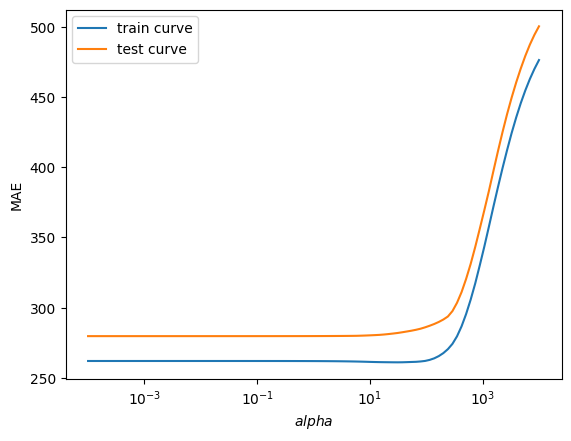

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the validation curves
plt.semilogx(gs_results["alpha"], gs_results["train_mae"], label="train curve")
plt.semilogx(gs_results["alpha"], gs_results["test_mae"], label="test curve")
plt.xlabel("$alpha$")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [16]:
# Create the pipeline
pipe = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge())])
pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('ridge', Ridge())],
 'verbose': False,
 'scaler': StandardScaler(),
 'ridge': Ridge(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'ridge__alpha': 1.0,
 'ridge__copy_X': True,
 'ridge__fit_intercept': True,
 'ridge__max_iter': None,
 'ridge__positive': False,
 'ridge__random_state': None,
 'ridge__solver': 'auto',
 'ridge__tol': 0.0001}

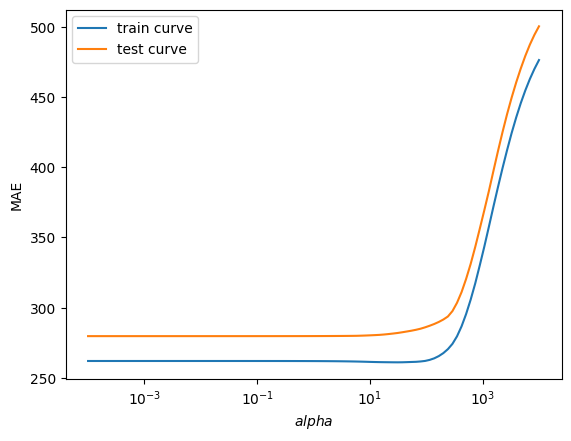

In [17]:
# Variable to store the results
gs_results = []

# Grid search
for alpha in np.logspace(-4, 4, num=100):
    # Fit the pipeline
    pipe.set_params(ridge__alpha=alpha)
    pipe.fit(X_tr, y_tr)

    # Save model and its performance on train/test sets
    gs_results.append(
        {
            "alpha": alpha,
            "train_mae": MAE(y_tr, pipe.predict(X_tr)),
            "test_mae": MAE(y_te, pipe.predict(X_te)),
        }
    )

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)

# Plot the validation curves
plt.semilogx(gs_results["alpha"], gs_results["train_mae"], label="train curve")
plt.semilogx(gs_results["alpha"], gs_results["test_mae"], label="test curve")
plt.xlabel("$alpha$")
plt.ylabel("MAE")
plt.legend()
plt.show()

# 3. Column transformations

 So far in this program, we have seen how to structure our data analysis into (1) data preparation (2) exploratory data analysis (EDA) and (3) machine learning parts. The first two steps (1) and (2) involve a lot of data manipulation and are done in Pandas and the last one (3) with Scikit-learn. Because ML models only work with numerical data, we usually convert our DataFrame into a Numpy float 2d array only at step (3) for sklearn estimators. It’s important to understand that the data preprocessing (1) and (2) are done in Pandas. The only exception is for common preprocessing steps that are very specific to ML such as StandardScaler or dimensionality reduction such as PCA (more about this in the next course) - those are usually encapsulated into a Pipeline object as shown in the last unit. The reason for this exception is simple: those ML operations are independent of the nature of the column unlike the data manipulation steps from (1) and (2) that are usually very specific to each variable. For instance, feature engineering and outliers removal are done in Pandas because they depend on the type of variable and their meaning ex. it doesn’t make sense to create polynomial features for categories or apply z-score outliers removal to ordinal variables or skewed ones.

__One-hot encoding with Scikit-learn__

In [18]:
import pandas as pd

data_df = pd.read_csv("c3_bike-sharing-data.csv")
data_df.head()

,temp,hum,windspeed,yr,workingday,holiday,weekday,season,weathersit,casual
0,0.344,0.806,0.160,2011,no,no,6,spring,cloudy,331
1,0.363,0.696,0.249,2011,no,no,0,spring,cloudy,131
2,0.196,0.437,0.248,2011,yes,no,1,spring,clear,120
3,0.200,0.590,0.160,2011,yes,no,2,spring,clear,108
4,0.227,0.437,0.187,2011,yes,no,3,spring,clear,82


In [19]:
from sklearn.preprocessing import OneHotEncoder

# Create encoder
encoder = OneHotEncoder()
encoder.fit_transform(data_df)

<731x1714 sparse matrix of type '<class 'numpy.float64'>'
	with 7310 stored elements in Compressed Sparse Row format>

The result can be a bit surprising at first sight: we pass a DataFrame object and get a sparse matrix with 1,714 columns! In fact, the transformer encodes all the columns from the input data, including the numerical ones. So it creates a new one-hot encoded column for each distinct value in the DataFrame.

__ColumnTransformer object__

In [20]:
from sklearn.compose import ColumnTransformer

# Handle categorical variables
cat_columns = ["yr", "workingday", "holiday", "weekday", "season", "weathersit"]
cat_transformer = OneHotEncoder(sparse=False)

# Create the column transformer
preprocessor = ColumnTransformer(
    [("categorical", cat_transformer, cat_columns)], remainder="passthrough"
)

In [21]:
encoded = preprocessor.fit_transform(data_df)
encoded

/home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1.00e+00, 0.00e+00, 1.00e+00, ..., 8.06e-01, 1.60e-01, 3.31e+02],
       [1.00e+00, 0.00e+00, 1.00e+00, ..., 6.96e-01, 2.49e-01, 1.31e+02],
       [1.00e+00, 0.00e+00, 0.00e+00, ..., 4.37e-01, 2.48e-01, 1.20e+02],
       ...,
       [0.00e+00, 1.00e+00, 1.00e+00, ..., 7.53e-01, 1.24e-01, 1.59e+02],
       [0.00e+00, 1.00e+00, 1.00e+00, ..., 4.83e-01, 3.51e-01, 3.64e+02],
       [0.00e+00, 1.00e+00, 0.00e+00, ..., 5.78e-01, 1.55e-01, 4.39e+02]])

In [22]:
print("Shape:", encoded.shape)
print("Type:", type(encoded))
print("Data type:", encoded.dtype)

Shape: (731, 24)
Type: <class 'numpy.ndarray'>
Data type: float64


In [23]:
try:
    cat_transformer.get_feature_names_out()
except Exception as e:
    print(e)

This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.


In [24]:
preprocessor.named_transformers_

{'categorical': OneHotEncoder(sparse=False, sparse_output=False),
 'remainder': 'passthrough'}

In [25]:
preprocessor.named_transformers_["categorical"].get_feature_names_out()

array(['yr_2011', 'yr_2012', 'workingday_no', 'workingday_yes',
       'holiday_no', 'holiday_yes', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'season_fall',
       'season_spring', 'season_summer', 'season_winter',
       'weathersit_clear', 'weathersit_cloudy', 'weathersit_rainy'],
      dtype=object)

__Issue with missing categories__

In [26]:
new_data = data_df.iloc[:1].copy()
new_data["weathersit"] = "storm"
new_data

,temp,hum,windspeed,yr,workingday,holiday,weekday,season,weathersit,casual
0,0.344,0.806,0.16,2011,no,no,6,spring,storm,331


In [27]:
try:
    preprocessor.transform(new_data)
except Exception as e:
    print(e)

Found unknown categories ['storm'] in column 5 during transform


The one-hot encoder returns an exception saying that 'storm' is an unknown value. A common practice is to simply ignore unseen values and set all the corresponding one-hot encoded variables to zero i.e. x5_clear, x5_cloudy and x5_rainy.

We can specify this behavior by setting the handle_unknown attribute of our OneHotEncoder

In [29]:
# Handle categorical variables
cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Create the column transformer
preprocessor = ColumnTransformer(
    [("categorical", cat_transformer, cat_columns)], remainder="passthrough"
)
preprocessor.fit_transform(data_df)
preprocessor.transform(new_data)

/home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 3.44e-01, 8.06e-01, 1.60e-01, 3.31e+02]])

__Ordinal encoding with Scikit-learn__

In [30]:
from sklearn.preprocessing import OrdinalEncoder

# Handle ordinal variables
ord_columns = ["weathersit"]
ord_transformer = OrdinalEncoder(categories=[["clear", "cloudy", "rainy"]])

__FunctionTransformer object__

In [31]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Add polynomial features
poly_columns = ["temp", "hum", "windspeed"]
poly_transformer = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("poly", FunctionTransformer(lambda X: np.c_[X, X ** 2, X ** 3])),
    ]
)

Note that our transformer from above is not equivalent to the PolynomialFeatures one which adds all the interaction terms in addition to the polynomial features.

In [32]:
from sklearn.preprocessing import PolynomialFeatures

polyfeat = PolynomialFeatures(degree=3, include_bias=False)
polyfeat.fit(data_df[poly_columns])
polyfeat.get_feature_names_out()

array(['temp', 'hum', 'windspeed', 'temp^2', 'temp hum', 'temp windspeed',
       'hum^2', 'hum windspeed', 'windspeed^2', 'temp^3', 'temp^2 hum',
       'temp^2 windspeed', 'temp hum^2', 'temp hum windspeed',
       'temp windspeed^2', 'hum^3', 'hum^2 windspeed', 'hum windspeed^2',
       'windspeed^3'], dtype=object)

__Complete pipeline__

In [33]:
# Create the column transformer
preprocessor = ColumnTransformer(
    [
        ("categorical", cat_transformer, cat_columns),
        ("ordinal", ord_transformer, ord_columns),
        ("poly", poly_transformer, poly_columns),
    ],
    remainder="drop",
)

encoded = preprocessor.fit_transform(data_df)
encoded.shape

/home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(731, 30)

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Create Pipeline
pipe = Pipeline([("preprocessor", preprocessor), ("regressor", LinearRegression())])

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE

# Split into train/test sets
X = data_df.drop("casual", axis=1)
y = data_df.casual
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit/evaluate pipeline
pipe.fit(X_tr, y_tr)
print("MAE: {:.2f}".format(MAE(y_te, pipe.predict(X_te))))

MAE: 253.03


/home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
